In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [ ]:
import os

In [ ]:
#read the train.csv file
from google.colab import files
uploaded1 = files.upload()

Saving train.csv to train.csv


In [ ]:
#read the test.csv file
from google.colab import files
uploaded2 = files.upload()

Saving test.csv to test.csv


In [ ]:
#getting a basic idea 
tweet = pd.read_csv(io.BytesIO(uploaded1['train.csv']))
test = pd.read_csv(io.BytesIO(uploaded2['test.csv']))
tweet.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [ ]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


Text(0, 0.5, 'samples')

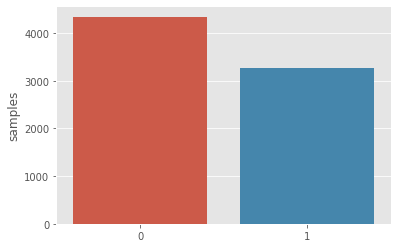

In [ ]:
#check class distribution in trainset 
x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

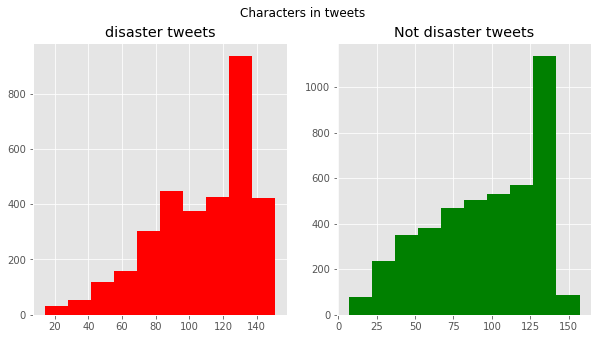

In [ ]:
#number of characters in tweets 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

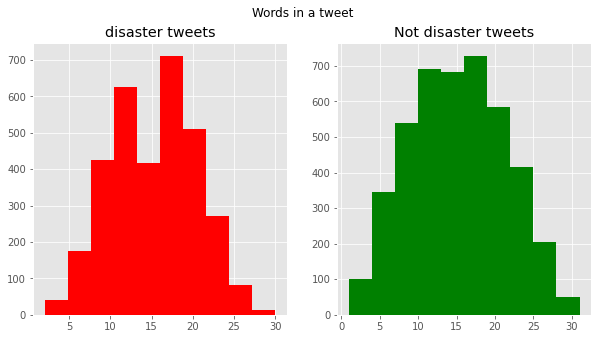

In [ ]:
#number of words in a tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

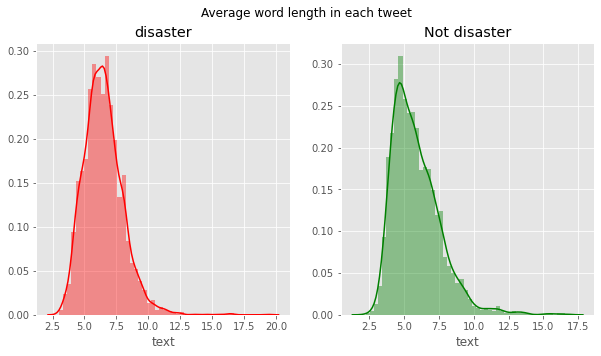

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')


In [ ]:
#create corpus according to target number
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
#we start with tweets from class 0 (no disaster)
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

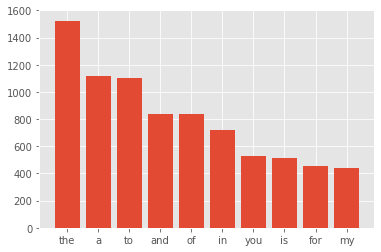

In [ ]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

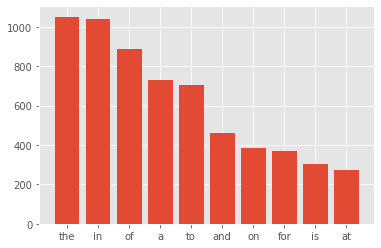

In [ ]:
#now we analyze common stop words in corpus of class 1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 18 artists>

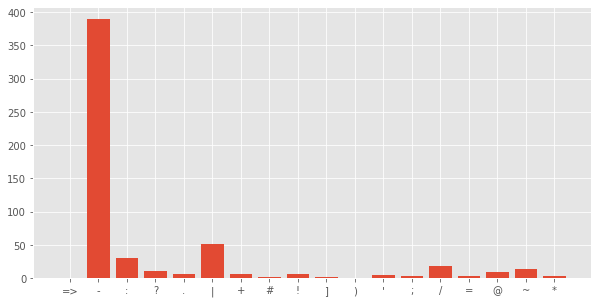

In [ ]:
#Now we analyze punctuations for class 1
plt.figure(figsize=(10,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

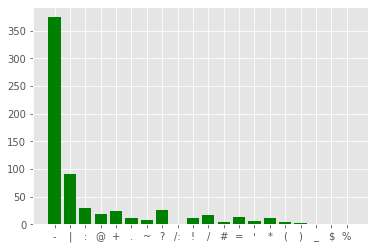

In [ ]:
#do same thing with class 1
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In [ ]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

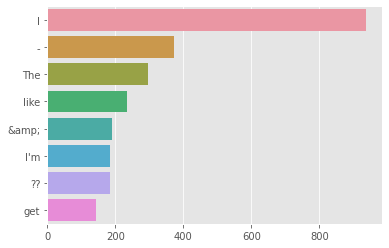

In [ ]:
sns.barplot(x=y,y=x)

In [ ]:
#Now we do an Ngram analysis (bigram = 2) so we check the most common bigrams in a tweet 
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

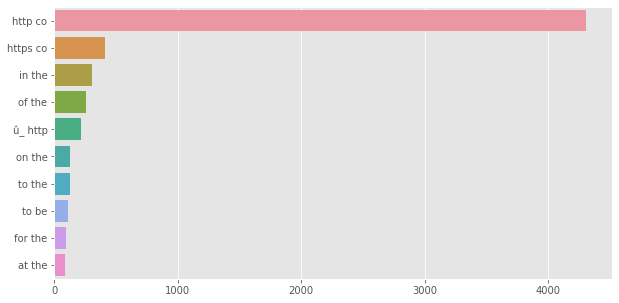

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

In [ ]:
#Data cleaning 
import pandas as pd                     
import io
"""
We do some basic cleaning such as spelling correction, removing punctuations, removing html tags and emojis etc..
"""
df=pd.concat([tweet,test])

df.shape

(10876, 5)

In [ ]:
#Removing urls
example="New competition launched :https://www.google.com"
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [ ]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [ ]:
#Remove the html tags 
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [ ]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [ ]:
df['text']=df['text'].apply(lambda x : remove_html(x))

In [ ]:
#remove emojis
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("OMG another Earthquake 😔😔")

'OMG another Earthquake '

In [ ]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [ ]:
def remove_punct(text):
  table=str.maketrans('','',string.punctuation)
  return text.translate(table)

example = '#I am a king.'
print(remove_punct(example))

I am a king


In [ ]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [ ]:
#Now we do some spelling correction 
!pip install pyspellchecker

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
  corrected_text=[]
  misspelled_words=spell.unknown(text.split())
  for word in text.split():
    if word in misspelled_words: 
      corrected_text.append(spell.correction(word))
    else:
      corrected_text.append(word)
  return " ".join(corrected_text)

text = "corect me plese, you are a good husbind"
correct_spellings(text)

'correct me please you are a good husband'

In [ ]:
df['text']=df['text'].apply(lambda x : correct_spellings(x))


KeyboardInterrupt: ignored

In [ ]:
>>> nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> wordnet
      Unzipping corpora/wordnet.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
>>> from nltk.corpus import wordnet as wn


In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize_stem(text):
    
    token_words = word_tokenize(text)
    stem_words =[]
    for i in token_words:
        word = lemmatizer.lemmatize(i)
        stem_words.append(word)
        
    final_tweet = ' '.join(stem_words)
    
    return final_tweet
                                                            
                                                        


In [ ]:
df['text'] = df['text'].apply(lambda x: tokenize_stem(x))


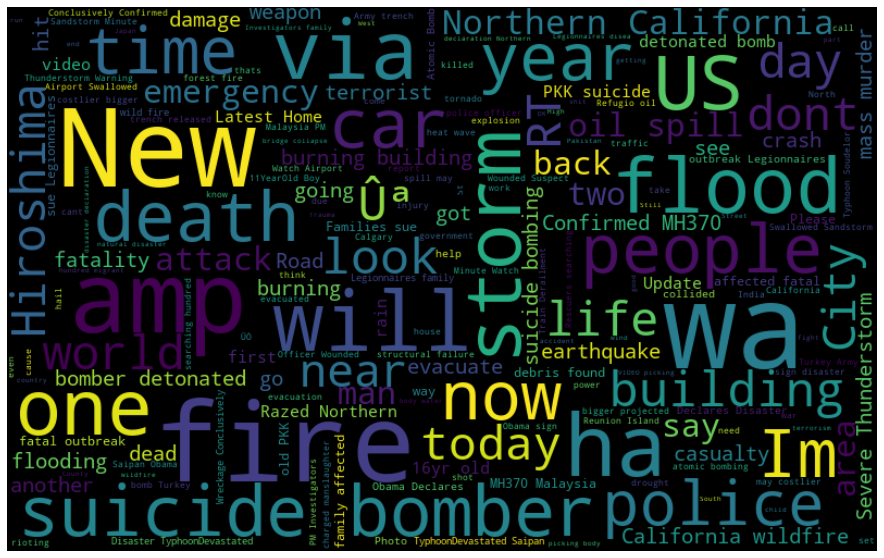

In [ ]:
all_words = ' '.join([text for text in df['text'][df['target']==1]])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['text'])

In [ ]:
tfidf.shape

(10876, 4685)

In [ ]:
Final_train = tfidf[:7613]
Final_test = tfidf[7613:]

In [ ]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score


xtrain = Final_train[:5331]
xvalid = Final_train[5331:]
ytrain = df[:5331]['target']
yvalid = df[5331:7613]['target']

clf = BernoulliNB()
clf.fit(xtrain, ytrain)
NB_Clf = MultinomialNB()
NB_Clf.fit(xtrain, ytrain)



pred_naive = NB_Clf.predict(xvalid)
conf = confusion_matrix(yvalid, pred_naive)
print(conf)

f1score = f1_score(yvalid,pred_naive)
recall = recall_score(yvalid, pred_naive, average='micro')
precision = precision_score(yvalid, pred_naive, average='micro')
print('F1 Score : %.3f' %(f1score))
print('recall Score : %.3f' %(recall))
print('precision Score : %.3f' %(precision))

pred_naive_test = NB_Clf.predict(Final_test)
pred_naive_test = pred_naive_test.astype(int)

[[1091  182]
 [ 363  646]]
F1 Score : 0.703
recall Score : 0.761
precision Score : 0.761


In [ ]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(yvalid, pred_naive)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.66


Text(0.5, 1.0, 'Precision-Recall curve: AP=0.66')

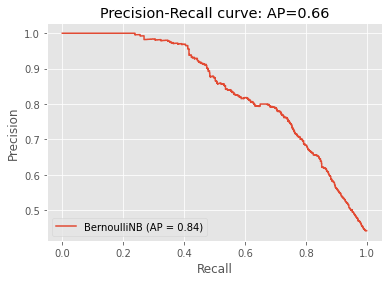

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf, xvalid, yvalid)
disp.ax_.set_title('Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [ ]:
from sklearn.metrics import classification_report

target_names = ['not relevant', 'relevant']
print(classification_report(yvalid, pred_naive, target_names=target_names))

              precision    recall  f1-score   support

not relevant       0.73      0.75      0.74      1273
    relevant       0.67      0.65      0.66      1009

    accuracy                           0.71      2282
   macro avg       0.70      0.70      0.70      2282
weighted avg       0.70      0.71      0.71      2282



In [ ]:
confusion_matrix(yvalid,pred_naive)

array([[951, 322],
       [350, 659]])

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}
SVM_Model = GridSearchCV(SVC(kernel='poly'), param_grid, cv=3, n_jobs=-1).fit(xtrain, ytrain)

In [ ]:
pred_SVM_valid = SVM_Model.predict(xvalid)
pred_SVM_valid = pred_SVM_valid.astype(int)

conf = confusion_matrix(yvalid, pred_SVM_valid)
print(conf)

f1score = f1_score(yvalid,pred_SVM_valid)
recall = recall_score(yvalid,pred_SVM_valid, average='micro')
precision = precision_score(yvalid,pred_SVM_valid, average='micro')
print('F1 Score : %.3f' %(f1score))
print('recall Score : %.3f' %(recall))
print('precision Score : %.3f' %(precision))

[[1046  227]
 [ 441  568]]
F1 Score : 0.630
recall Score : 0.707
precision Score : 0.707


In [ ]:
from sklearn.metrics import classification_report

target_names = ['not relevant', 'relevant']
print(classification_report(yvalid, pred_SVM_valid, target_names=target_names))

              precision    recall  f1-score   support

not relevant       0.70      0.82      0.76      1273
    relevant       0.71      0.56      0.63      1009

    accuracy                           0.71      2282
   macro avg       0.71      0.69      0.69      2282
weighted avg       0.71      0.71      0.70      2282



Text(0.5, 1.0, 'Precision-Recall curve: AP=0.60')

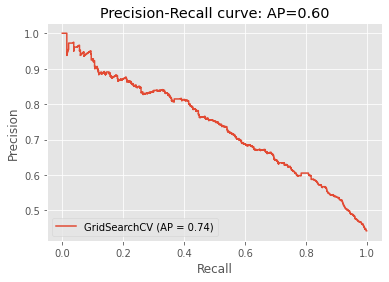

In [ ]:
average_precision = average_precision_score(yvalid, pred_SVM_valid)
disp = plot_precision_recall_curve(SVM_Model, xvalid, yvalid)
disp.ax_.set_title('Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))